In [11]:
from wann_genetic.tools import ExperimentSeries, mean_comparison
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import permutations
import pandas as pd
from wann_genetic.individual.numpy import Individual
from scipy.stats import ttest_rel, ttest_ind
from tabulate import tabulate

In [2]:
# set output format to svg
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

In [3]:
series = ExperimentSeries.from_spec_file("../data/iris_act_funcs/shapley_approx_wo_signs")
series.discover_data_dir()
df = series.assemble_stats()
function_names = [name[:4] for name, _ in Individual.Phenotype.available_act_functions]

In [4]:
accuracies = dict()

for index, row in df.iterrows():
    accuracies[tuple(sorted(row['activation_functions']))] = row['mean accuracy']

marginal_gains = list()
    
for (co1, acc1), (co2, acc2) in permutations(accuracies.items(), 2):
    if (len(co1) == len(co2) - 1) and set(co1).issubset(co2):
        element, = [e for e in co2 if e not in co1]
        marginal_gains.append({'activation function': function_names[element], 'marginal gain': acc2 - acc1})
            
marginal_gains = pd.DataFrame(marginal_gains)

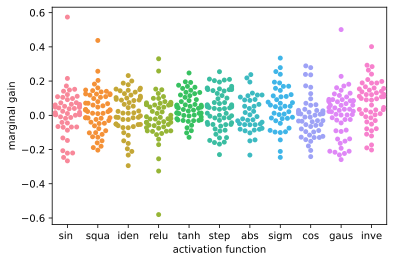

In [5]:
sns.swarmplot(x="activation function", y="marginal gain", data=marginal_gains)
plt.show()

In [6]:
for i,f in enumerate(function_names):
    df[f] = [i in row['activation_functions'] for index, row in df.iterrows()]

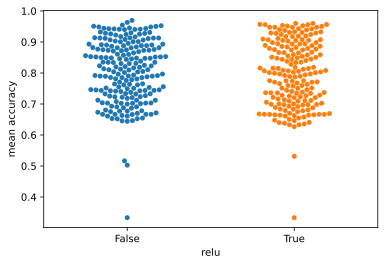

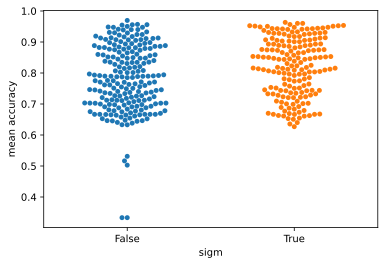

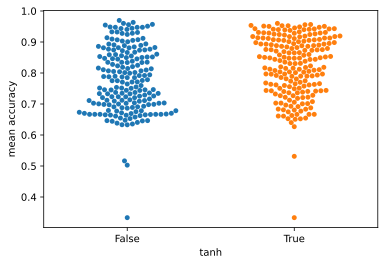

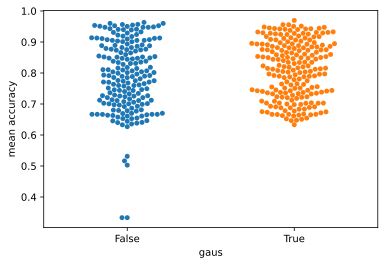

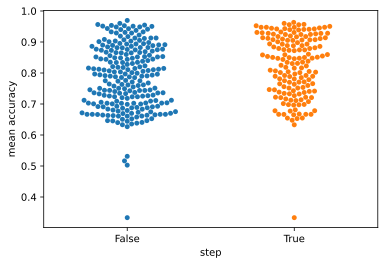

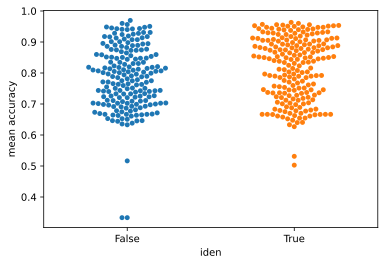

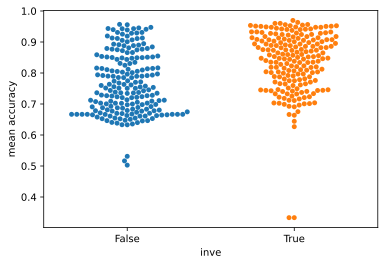

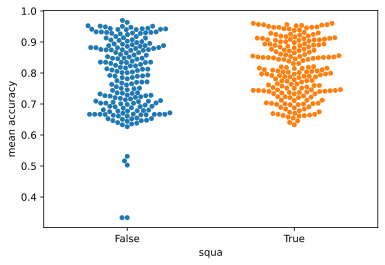

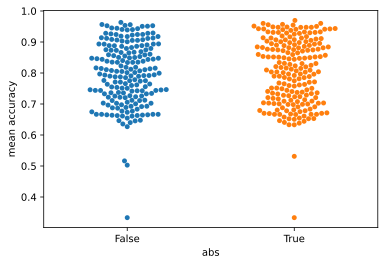

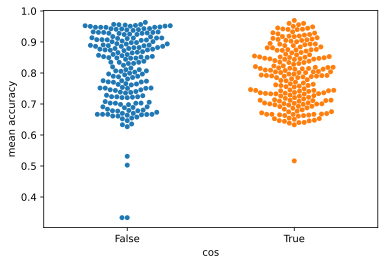

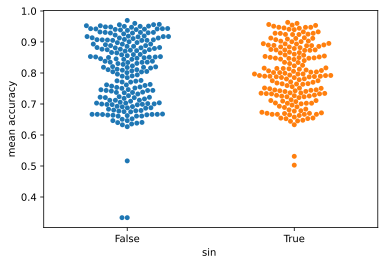

In [7]:
for f in function_names:
    sns.swarmplot(x=f, y="mean accuracy", data=df)
    plt.show()

In [8]:
df

,mean accuracy,max accuracy,min accuracy,mean kappa,max kappa,min kappa,mean log_loss,max log_loss,min log_loss,activation_functions,...,sigm,tanh,gaus,step,iden,inve,squa,abs,cos,sin
0,0.881133,0.960000,0.666667,0.8217,0.94,5.000000e-01,0.431211,0.957000,0.196879,"[1, 3, 5, 7, 8, 9]",...,True,False,True,False,True,False,True,True,True,False
1,0.732267,0.960000,0.333333,0.5984,0.94,0.000000e+00,0.820329,1.659839,0.471745,"[1, 2, 3, 4, 6, 8, 9]",...,True,True,True,True,False,True,False,True,True,False
2,0.646333,0.953333,0.333333,0.4695,0.93,0.000000e+00,1.117192,5.744294,0.886743,"[8, 9]",...,False,False,False,False,False,False,False,True,True,False
3,0.881267,0.960000,0.333333,0.8219,0.94,8.326673e-17,0.658634,1.734014,0.370790,"[3, 4, 5, 6, 8, 9]",...,False,False,True,True,True,True,False,True,True,False
4,0.662533,0.960000,0.433333,0.4938,0.94,1.500000e-01,7.899724,23.025851,0.795776,"[0, 1, 3, 5, 7, 9]",...,True,False,True,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,0.885800,0.960000,0.333333,0.8287,0.94,0.000000e+00,0.649127,9.091406,0.275154,"[0, 1, 3, 4, 6, 8, 10]",...,True,False,True,True,False,True,False,True,False,True
390,0.918867,0.940000,0.866667,0.8783,0.91,8.000000e-01,0.461950,1.892127,0.219386,"[0, 2, 5, 7, 9]",...,False,True,False,False,True,False,True,False,True,False
391,0.721600,0.960000,0.426667,0.5824,0.94,1.400000e-01,1.790311,17.279436,0.694526,"[0, 1, 2, 3, 4, 5, 9]",...,True,True,True,True,True,False,False,False,True,False
392,0.770600,0.960000,0.333333,0.6559,0.94,0.000000e+00,0.966574,11.306202,0.652090,"[0, 4, 5, 6, 9]",...,False,False,False,True,True,True,False,False,True,False


In [9]:
accuracies = dict()

for index, row in df.iterrows():
    accuracies[tuple(sorted(row['activation_functions']))] = row['mean accuracy']

paired_samples = list()
    
for (co1, acc1), (co2, acc2) in permutations(accuracies.items(), 2):
    if (len(co1) == len(co2) - 1) and set(co1).issubset(co2):
        element, = [e for e in co2 if e not in co1]
        paired_samples.append({'activation function': function_names[element], 'acc with': acc2, 'acc without': acc1})

paired_samples = pd.DataFrame(paired_samples)

In [22]:
rows = list()
for fn in function_names:
    data = paired_samples[paired_samples['activation function'] == fn]
    t, p = ttest_rel(data['acc with'], data['acc without'])
    cells = [fn, f"{t:.2}", f"{p:.2%}"]
    if p < 0.05:
        cells = [f"**{cell}**" for cell in cells]
    rows.append(cells)
print(tabulate(rows, tablefmt='grid', headers=('activation function', 't-value', 'p-value')))

+-----------------------+-----------+-----------+
| activation function   | t-value   | p-value   |
+=======================+===========+===========+
| relu                  | -0.56     | 57.96%    |
+-----------------------+-----------+-----------+
| **sigm**              | **2.4**   | **1.90%** |
+-----------------------+-----------+-----------+
| **tanh**              | **4.2**   | **0.01%** |
+-----------------------+-----------+-----------+
| gaus                  | 0.61      | 54.52%    |
+-----------------------+-----------+-----------+
| **step**              | **2.5**   | **1.56%** |
+-----------------------+-----------+-----------+
| iden                  | 1.1       | 25.70%    |
+-----------------------+-----------+-----------+
| **inve**              | **4.1**   | **0.01%** |
+-----------------------+-----------+-----------+
| squa                  | 1.6       | 10.56%    |
+-----------------------+-----------+-----------+
| abs                   | 0.46      | 64.78%    |
